# Examples

In [1]:
import xevent
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
import warnings

warnings.filterwarnings("ignore")

xr.set_options(display_expand_data=False)

np.random.seed(42)

## Example 1: Heat waves in a time series

In [3]:
# sample DataArray with dimension "time"
times = pd.date_range("2000-01-01", periods=100, freq="D")
da = xr.DataArray(np.random.rand(100), dims=["time"], coords={"time": times})
da

<xarray.DataArray (time: 100)>
0.3745 0.9507 0.732 0.5987 0.156 0.156 ... 0.4938 0.5227 0.4275 0.02542 0.1079
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-04-09

In [4]:
# sample events dictionary
events = [
    {"time": np.datetime64("2000-01-11")},
    {"time": np.datetime64("2000-02-22")},
]

relative_time = pd.timedelta_range("-5D", "5D")
xevent.composite(da, events, relative_coords=dict(time=relative_time))

<xarray.DataArray (event: 2, rel_time: 11)>
0.156 0.05808 0.8662 0.6011 0.7081 ... 0.8948 0.5979 0.9219 0.08849 0.196
Coordinates:
    time      (event, rel_time) datetime64[ns] 2000-01-06 ... 2000-02-27
  * event     (event) int64 0 1
  * rel_time  (rel_time) timedelta64[ns] -5 days -4 days ... 4 days 5 days

## Example 2: Radiosonde profiles relative to tropopause

In [5]:
# sample DataArray with N radiosonde profiles with M levels each
N = 100
M = 30
profiles = pd.date_range("2000-01-01", periods=N)
levels = np.arange(M)

da = xr.DataArray(
    np.random.rand(N, M),
    dims=["profile", "level"],
    coords={"profile": profiles, "level": levels},
)
da

<xarray.DataArray (profile: 100, level: 30)>
0.03143 0.6364 0.3144 0.5086 0.9076 ... 0.6725 0.977 0.1019 0.00832 0.4336
Coordinates:
  * profile  (profile) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-04-09
  * level    (level) int64 0 1 2 3 4 5 6 7 8 9 ... 20 21 22 23 24 25 26 27 28 29

In [6]:
tropopauses = [
    {"profile": np.datetime64("2000-01-11"), "level": 10},
    {"profile": np.datetime64("2000-02-22"), "level": 20},
]

relative_levels = np.arange(-5, 6)
xevent.composite(da, events=tropopauses, relative_coords=dict(level=relative_levels))

<xarray.DataArray (event: 2, rel_level: 11)>
0.8955 0.3892 0.01084 0.9054 0.09129 0.3193 ... 0.9756 0.641 0.8225 0.1325 0.862
Coordinates:
    profile    (event) datetime64[ns] 2000-01-11 2000-02-22
    level      (event, rel_level) int64 5 6 7 8 9 10 11 ... 19 20 21 22 23 24 25
  * event      (event) int64 0 1
  * rel_level  (rel_level) int64 -5 -4 -3 -2 -1 0 1 2 3 4 5

## Example 3: Time advantage compared to looping over events

In [7]:
# sample DataArray with nlon longitudes and nlat latitudes and ntime times
nlon = 360
nlat = 181
ntime = 100
lon = np.linspace(-180, 179, nlon)
lat = np.linspace(-90, 90, nlat)
time = pd.date_range("2000-01-01", periods=ntime)
da = xr.DataArray(
    np.random.rand(ntime, nlat, nlon),
    dims=["time", "lat", "lon"],
    coords={"time": time, "lat": lat, "lon": lon},
)
da

<xarray.DataArray (time: 100, lat: 181, lon: 360)>
0.09263 0.7484 0.9145 0.434 0.2587 0.4344 ... 0.247 0.9644 0.4387 0.8104 0.704
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-04-09
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0

In [8]:
da.nbytes / 1e6  # in MB

52.128

In [9]:
events = [
    {
        "time": np.random.choice(time),
        "lat": np.random.choice(lat),
        "lon": np.random.choice(lon),
    }
    for _ in range(10_000)
]

In [10]:
rel_lon = np.arange(-5, 6)
rel_lat = np.arange(-5, 6)
rel_time = pd.timedelta_range("-5D", "5D")

%time composite = xevent.composite(da, events, relative_coords=dict(lon=rel_lon, lat=rel_lat, time=rel_time))
composite

CPU times: user 335 ms, sys: 51.8 ms, total: 387 ms
Wall time: 384 ms


<xarray.DataArray (event: 10000, rel_time: 11, rel_lat: 11, rel_lon: 11)>
0.5204 0.2114 0.9221 0.2079 0.2641 ... 0.002464 0.2175 0.7792 0.6119 0.283
Coordinates:
    time      (event, rel_time) datetime64[ns] 2000-01-25 ... 2000-02-09
    lat       (event, rel_lat) float64 74.0 75.0 76.0 77.0 ... -83.0 -82.0 -81.0
    lon       (event, rel_lon) float64 148.0 149.0 150.0 ... 151.0 152.0 153.0
  * event     (event) int64 0 1 2 3 4 5 6 ... 9993 9994 9995 9996 9997 9998 9999
  * rel_lon   (rel_lon) int64 -5 -4 -3 -2 -1 0 1 2 3 4 5
  * rel_lat   (rel_lat) int64 -5 -4 -3 -2 -1 0 1 2 3 4 5
  * rel_time  (rel_time) timedelta64[ns] -5 days -4 days ... 4 days 5 days

In [11]:
def looping_composite():
    result = []
    for e in events:
        event_center = da.sel(lon=e["lon"], lat=e["lat"], time=e["time"])
        subset = da.sel(
            lon=slice(e["lon"] - 5, e["lon"] + 5),
            lat=slice(e["lat"] - 5, e["lat"] + 5),
            time=slice(e["time"] - pd.Timedelta("5D"), e["time"] + pd.Timedelta("5D")),
        )
        rel_coords = dict(
            rel_lon=subset.lon - event_center.lon,
            rel_lat=subset.lat - event_center.lat,
            rel_time=subset.time - event_center.time,
        )
        result.append(subset.assign_coords(**rel_coords).swap_dims(lon="rel_lon", lat="rel_lat", time="rel_time"))
    return  xr.concat(result, dim="event").assign_coords(event=np.arange(len(events)))


%time xarray_result = looping_composite()
xarray_result

CPU times: user 1min 4s, sys: 165 ms, total: 1min 4s
Wall time: 1min 4s


<xarray.DataArray (event: 10000, rel_time: 11, rel_lat: 11, rel_lon: 11)>
0.5204 0.2114 0.9221 0.2079 0.2641 ... 0.002464 0.2175 0.7792 0.6119 0.283
Coordinates:
  * rel_lon   (rel_lon) float64 -5.0 -4.0 -3.0 -2.0 -1.0 0.0 1.0 2.0 3.0 4.0 5.0
  * rel_lat   (rel_lat) float64 -5.0 -4.0 -3.0 -2.0 -1.0 0.0 1.0 2.0 3.0 4.0 5.0
  * rel_time  (rel_time) timedelta64[ns] -5 days -4 days ... 4 days 5 days
    time      (event, rel_time) datetime64[ns] 2000-01-25 ... 2000-02-09
    lat       (event, rel_lat) float64 74.0 75.0 76.0 77.0 ... -83.0 -82.0 -81.0
    lon       (event, rel_lon) float64 148.0 149.0 150.0 ... 151.0 152.0 153.0
  * event     (event) int64 0 1 2 3 4 5 6 ... 9993 9994 9995 9996 9997 9998 9999

In [12]:
xr.testing.assert_equal(
    xarray_result.drop_vars(["lon", "lat", "time"]),
    composite.drop_vars(["lon", "lat", "time"]),
)

## Example 4: Finding events

Say there is a DataArray with 100 timesteps and 360 longitudes.

Events are timesteps, where the value of 10 consecutive longitudes is greater than 0.
If this is the case, then the event center is the last longitude of that block only a maximum of one event per time step is allowed.

In [13]:
# sample dataarray with 100 time steps and 360 longitudes
np.random.seed(42)
da = xr.DataArray(
    np.random.normal(size=(100, 360)),
    dims=["time", "lon"],
    coords={
        "time": pd.date_range("2000-01-01", periods=100),
        "lon": np.linspace(-180, 179, 360),
    },
    name="u",
)
da

<xarray.DataArray 'u' (time: 100, lon: 360)>
0.4967 -0.1383 0.6477 1.523 -0.2342 ... -1.049 -0.4573 0.3573 0.8693 0.08282
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-04-09
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0

### Looping

In [14]:
events = []
for t in da.time:
    da_selected_t = da.sel(time=t)
    blocks_in_question = da_selected_t.rolling(lon=10).min() > 0
    if blocks_in_question.max() == False:
        # no event
        continue
    else:
        # first longitude of the block (argmax points to first True value)
        lon_event_start = blocks_in_question.lon.isel(lon=blocks_in_question.argmax())
        events.append({"time": t.values, "lon": lon_event_start.values.item()})
print("Number of events:", len(events))
events

Number of events: 13


[{'time': numpy.datetime64('2000-01-08T00:00:00.000000000'), 'lon': 7.0},
 {'time': numpy.datetime64('2000-01-13T00:00:00.000000000'), 'lon': -25.0},
 {'time': numpy.datetime64('2000-01-20T00:00:00.000000000'), 'lon': -7.0},
 {'time': numpy.datetime64('2000-02-10T00:00:00.000000000'), 'lon': -53.0},
 {'time': numpy.datetime64('2000-02-25T00:00:00.000000000'), 'lon': 151.0},
 {'time': numpy.datetime64('2000-03-01T00:00:00.000000000'), 'lon': 110.0},
 {'time': numpy.datetime64('2000-03-06T00:00:00.000000000'), 'lon': -148.0},
 {'time': numpy.datetime64('2000-03-07T00:00:00.000000000'), 'lon': 57.0},
 {'time': numpy.datetime64('2000-03-13T00:00:00.000000000'), 'lon': -84.0},
 {'time': numpy.datetime64('2000-03-18T00:00:00.000000000'), 'lon': -103.0},
 {'time': numpy.datetime64('2000-03-23T00:00:00.000000000'), 'lon': -43.0},
 {'time': numpy.datetime64('2000-03-24T00:00:00.000000000'), 'lon': 8.0},
 {'time': numpy.datetime64('2000-04-02T00:00:00.000000000'), 'lon': -22.0}]

In [15]:
da_composite = xevent.composite(
    da,
    events,
    relative_coords=dict(lon=np.arange(-20, 40)),
)
da_composite

<xarray.DataArray 'u' (event: 13, rel_lon: 60)>
-1.536 0.7568 0.6125 -1.017 -0.2441 ... 0.5663 0.8754 1.342 1.107 -1.008
Coordinates:
    time     (event) datetime64[ns] 2000-01-08 2000-01-13 ... 2000-04-02
    lon      (event, rel_lon) float64 -13.0 -12.0 -11.0 -10.0 ... 15.0 16.0 17.0
  * event    (event) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * rel_lon  (rel_lon) int64 -20 -19 -18 -17 -16 -15 -14 ... 34 35 36 37 38 39

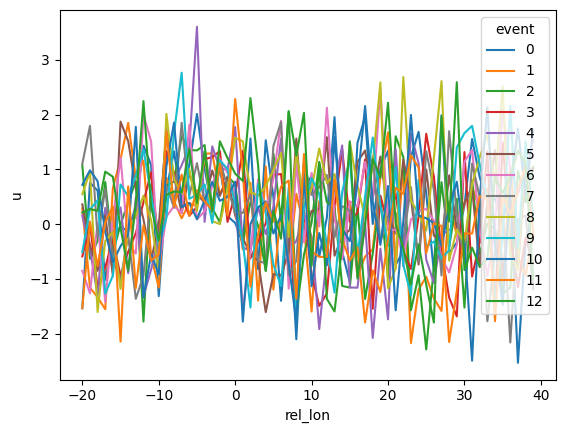

In [16]:
da_composite.plot(hue="event")

### Vectorized

In [17]:
lons_in_question = (da.rolling(lon=10).min() > 0).argmax("lon")
lons_in_question = lons_in_question.where(lons_in_question > 0, drop=True).astype("int")


event_centers = da.sel(time=lons_in_question.time).isel(lon=lons_in_question)
event_centers

<xarray.DataArray 'u' (time: 13)>
0.0239 0.5141 0.7321 0.555 1.774 0.1614 ... 1.576 0.3544 0.7754 2.285 0.9218
Coordinates:
  * time     (time) datetime64[ns] 2000-01-08 2000-01-13 ... 2000-04-02
    lon      (time) float64 7.0 -25.0 -7.0 -53.0 ... -103.0 -43.0 8.0 -22.0

In [18]:
events = event_centers.to_dataframe().reset_index()[["time", "lon"]].to_dict("records")
events

[{'time': Timestamp('2000-01-08 00:00:00'), 'lon': 7.0},
 {'time': Timestamp('2000-01-13 00:00:00'), 'lon': -25.0},
 {'time': Timestamp('2000-01-20 00:00:00'), 'lon': -7.0},
 {'time': Timestamp('2000-02-10 00:00:00'), 'lon': -53.0},
 {'time': Timestamp('2000-02-25 00:00:00'), 'lon': 151.0},
 {'time': Timestamp('2000-03-01 00:00:00'), 'lon': 110.0},
 {'time': Timestamp('2000-03-06 00:00:00'), 'lon': -148.0},
 {'time': Timestamp('2000-03-07 00:00:00'), 'lon': 57.0},
 {'time': Timestamp('2000-03-13 00:00:00'), 'lon': -84.0},
 {'time': Timestamp('2000-03-18 00:00:00'), 'lon': -103.0},
 {'time': Timestamp('2000-03-23 00:00:00'), 'lon': -43.0},
 {'time': Timestamp('2000-03-24 00:00:00'), 'lon': 8.0},
 {'time': Timestamp('2000-04-02 00:00:00'), 'lon': -22.0}]

In [19]:
da_composite = xevent.composite(
    da,
    events,
    relative_coords=dict(lon=np.arange(-20, 40)),
)

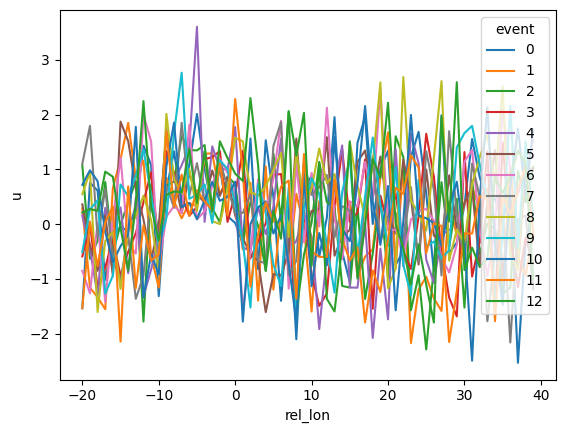

In [20]:
da_composite.plot(hue="event")